This script applies image recognition process to identify musical notes from an image.

Course: Computer Vision, SP 21, Indiana University, Bloomington

Assignment 1: OMR

Submission by: [Group 3] Aakash Ahuja, Sahil Tyagi, Rose Mariyappan, Ketan Pimparkar, Nicholas Faro 

Usage:
  omr.py <image_name> [--img_location=<loc>] [--with_test=<wt>]

Options:
  -h --help            Shows usage and other details
  --img_location=<loc> Path to the image.  [default: .]
  --with_test=<wt>     Compare results with standard libraries. [default: False]

In [100]:
#!pip install docopt
#!pip install Pillow==5.3.0

In [1]:
from docopt import docopt
from pathlib import Path
import numpy as np
from PIL import Image, ImageDraw, ImageFilter
import matplotlib.pyplot as plt
import sys
import glob
import os
from sklearn.preprocessing import minmax_scale
import math
from collections import Counter
import cv2

In [14]:
class omr:
    """
    Optical Music Recognition class
    """

    sobel_sx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) 
    sobel_sy = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) 
    
    sobel_separable_xx = np.array([[1],[2],[1]])
    sobel_separable_xy = np.array([[1,0,-1]])
    sobel_separable_yx = np.array([[1],[0],[-1]])
    sobel_separable_yy = np.array([[1,2,1]])

    def __init__(self, img_name, img_location=".", with_test=False) -> None:
        """
        Constructor method
        Args:
            img_name (str): name of the image. ex. music1.png
            img_location (str, optional): Location of the image. Defaults to "."
                                          ex. ./test-images
            with_test (bool, optional): Compare with standard libraries. 
                                        Defaults to False.
        """
        self.img_name = img_name
        self.img_file = Path(img_location, img_name)
        self.with_test = with_test
        self.img_obj = Image.open(self.img_file).convert("L")
        self.img_array = np.asarray(self.img_obj)
#        self.img_array = minmax_scale(np.asarray(self.img_obj)).astype(np.uint8)
        self.img_width = self.img_obj.width
        self.img_height = self.img_obj.height

        # parameters for Canny Edge Detector
        self.weak_pixel = 75       # 100
        self.strong_pixel = 255
        self.lowThreshold = 0.05   # 0.05
        self.highThreshold = 0.15  # 0.09 or 0.15 or 0.19
    
    def return_img_array(self):
        return self.img_obj, self.img_array

    def return_tmp_img_array(self, tmp_img_name, tmp_img_location="."):
        self.tmp_img_name = tmp_img_name
        self.tmp_img_file = Path(tmp_img_location, tmp_img_name)

        self.tmp_img_obj = Image.open(self.tmp_img_file).convert("L")
        self.tmp_img_array = np.asarray(self.tmp_img_obj)
#        self.tmp_img_array = minmax_scale(np.asarray(self.tmp_img_obj)).astype(np.uint8)
        self.tmp_img_width = self.tmp_img_obj.width
        self.tmp_img_height = self.tmp_img_obj.height
        return self.tmp_img_array, self.tmp_img_obj, self.tmp_img_width, self.tmp_img_height

    def convolve(self, array_name, kernel):
        """
        Method to perform 2D convolution of self.img_array and kernel.
        Args:
            kernel (np.Array): Kernel to used for the convolution.
        Return:
            Array resulted after the convolution having shape same as input 
            image array.
        """
        kernel_rows, kernel_cols = kernel.shape
        self.array_name = array_name
        img_rows, img_cols = self.array_name.shape

        print("image shape: ", self.array_name.shape)

        # flip the kernel
#        flipped_kernel = np.zeros(kernel.shape)
       
        ## column flips
#        for i in range(flipped_kernel.shape[1]):
#            flipped_kernel[:,i] = kernel[:,kernel_cols-i-1]
#        kernel = flipped_kernel.copy()

        ## row flips
#        for i in range(flipped_kernel.shape[0]):
#            flipped_kernel[i,:] = kernel[kernel_rows-i-1,:]
#        kernel = flipped_kernel.copy()
#        print("Flipped kernel:\n", kernel)

        # Handle broders by padding the image with white pixels.
        ## padwidth = kernel_rows // 2 
        r_pad = kernel_rows // 2
        c_pad = kernel_cols // 2
        self.array_name_padded = np.pad(self.array_name, pad_width=((r_pad,r_pad),(c_pad,c_pad)), \
                                        mode='constant', constant_values=255)
        
        # cross correlation
        self.array_name_out = np.zeros(self.array_name.shape)

        for x in range(img_rows):
            for y in range(img_cols):
                self.array_name_out[x, y] = \
                (np.multiply(np.flip(kernel), self.array_name_padded[x:x+kernel_rows, y:y+kernel_cols])).sum()
        
        return self.array_name_out


    def separable_convolve(self, array_name, h_kernel, v_kernel):
        """
        Method to perform 2D convolution in the horizontal and then vertical direction of self.img_array and kernel.
        Args:
            h_kernel (np.Array): Kernel used in the horizontal direction for the convolution.
            v_kernel (np.Array): Kernel used in the vertical direction for the convolution.
        Return:
            Array resulted after the convolution having shape same as input 
            image array.
        """
        self.array_name_output = self.convolve(self.convolve(array_name,h_kernel),v_kernel)
        return self.array_name_output
        
    def edge_detect_sobel(self, array_name, figsize=(10,8)):
        """
        Method to perform edge detection using sobel operator and 2D convolution
        """
        self.convolved_x = self.convolve(array_name, omr.sobel_sx)
        self.convolved_y = self.convolve(array_name, omr.sobel_sy)
        self.edge_map = np.sqrt(np.power(self.convolved_x,2) + np.power(self.convolved_y,2))
        
        if self.with_test:
            fig, axs = plt.subplots(2, 2, figsize=figsize)
            axs[0,0].imshow(array_name, 'gray')
            axs[0,0].set_title("Original image")
            axs[0,1].imshow(self.edge_map, 'gray')
            axs[0,1].set_title("Edge map of image")
            axs[1,0].imshow(self.convolved_x, 'gray')
            axs[1,0].set_title("Sobel_X convolution")
            axs[1,1].imshow(self.convolved_y, 'gray')
            axs[1,1].set_title("Sobel_Y convolution")
  
        self.edge_map = self.edge_map / self.edge_map.max() * 255
        self.edge_map_theta = np.arctan2(self.convolved_y, self.convolved_x)
        return self.edge_map, self.edge_map_theta
    
    def edge_detect_sobel_separable(self, array_name, figsize=(10,8)):
        """
        Method to perform edge detection using sobel operator and separable kernel convolutions
        """
        self.convolved_separable_x = self.separable_convolve(array_name, omr.sobel_separable_xy,omr.sobel_separable_xx)
        self.convolved_separable_y = self.separable_convolve(array_name, omr.sobel_separable_yy,omr.sobel_separable_yx)

        self.edge_map_separable = np.sqrt(np.power(self.convolved_separable_x,2) + np.power(self.convolved_separable_y,2))
        
        if self.with_test:
            fig, axs = plt.subplots(2, 2, figsize=figsize)
            axs[0,0].imshow(array_name, 'gray')
            axs[0,0].set_title("Original image")
            axs[0,1].imshow(self.edge_map_separable, 'gray')
            axs[0,1].set_title("Edge map of image (separable cov)")
            axs[1,0].imshow(self.convolved_separable_x, 'gray')
            axs[1,0].set_title("Sobel_X separable convolution")
            axs[1,1].imshow(self.convolved_separable_y, 'gray')
            axs[1,1].set_title("Sobel_Y separable convolution")

        self.edge_map_separable = self.edge_map_separable / self.edge_map_separable.max() * 255
        self.edge_map_separable_theta = np.arctan2(self.convolved_separable_y, self.convolved_separable_x)
        return self.edge_map_separable, self.edge_map_separable_theta

    # Below for Canny Edge Detection
    def non_max_suppression(self, img, D):
        M, N = img.shape
        Z = np.zeros((M,N), dtype=np.int32)
        angle = D * 180. / np.pi
        angle[angle < 0] += 180


        for i in range(1,M-1):
            for j in range(1,N-1):
                q = 255
                r = 255

                #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

        return Z

    # Below for Canny Edge Detection
    def threshold(self, img):

        highThreshold = img.max() * self.highThreshold;
        lowThreshold = highThreshold * self.lowThreshold;

        M, N = img.shape
        res = np.zeros((M,N), dtype=np.int32)

        weak = np.int32(25)
        strong = np.int32(255)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = strong
        res[weak_i, weak_j] = weak

        return (res)

    # Below for Canny Edge Detection
    def hysteresis(self, img):
        M, N = img.shape  
        weak = self.weak_pixel
        strong = self.strong_pixel
        for i in range(1, M-1):
            for j in range(1, N-1):
                if (img[i,j] == weak):
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
        return img

    def hamming_distance(self, edge_sobel_img_array, edge_sobel_tmp_img_array):

        #Padding the image to take care of boundaries 
        image_padded = np.zeros(shape=(edge_sobel_img_array.shape[0] + edge_sobel_tmp_img_array.shape[0] - 1, edge_sobel_img_array.shape[1] + edge_sobel_tmp_img_array.shape[1] -1))
        image_padded[:edge_sobel_img_array.shape[0], :edge_sobel_img_array.shape[1]] = edge_sobel_img_array

        #Calculating Hamming distance now for template matching
        f_ij = np.zeros((edge_sobel_img_array.shape[0],edge_sobel_img_array.shape[1]))
        for i in range(edge_sobel_img_array.shape[0]):
            for j in range(edge_sobel_img_array.shape[1]):
                patch = image_padded[i:i+edge_sobel_tmp_img_array.shape[0],j:j+edge_sobel_tmp_img_array.shape[1]]
                #Applying the formula given in the assignment
                f_ij[i,j] = np.sum(np.multiply(patch,edge_sobel_tmp_img_array)) + np.sum(np.multiply((1-patch),(1-edge_sobel_tmp_img_array)))
        f_ij_scaled = 255*(f_ij - f_ij.min())/(f_ij.max() - f_ij.min())      
        f_ij_scaled = f_ij_scaled.astype(np.uint8)
        print("f_ij_scaled ", f_ij_scaled)
        return(f_ij_scaled)

    def hough_transform(self, image):
        note_image = Image.open(image).convert('L')
        axis0_accum = note_image.height
        #the space to explore and vote for each black pixel in the black n' whitye grayscale image
        axis1_accum = math.floor(note_image.height / 5)
        accumulator = np.zeros([axis0_accum, axis1_accum])
        print(accumulator.shape)
        # all pixels lower than this value will be considered as black pixels, hopefully belonging to the lines of the staff.
        pixel_threshold = 180
        # for groups of five lines on a staff
        lines_to_detect = 5

        for x in range(0,note_image.width):
            for y in range(0,note_image.height):
                pixel_val = note_image.getpixel((x,y))
                if pixel_val < pixel_threshold:
                    for hough_axis1 in range(1, axis1_accum):
                        for space in range(0,lines_to_detect):
                            # following the format y = m*x + b where y is y-coord, x is x-coord, 
                            # m is slope and b is bias. x and y are in image space, while m and b are in hough space
                            # to detect five lines groups, we subsitute b with row coordinate of the first stave line
                            # and m by the spacing between the lines
                            hough_axis0 = abs(space * hough_axis1 + y)
                            # ignore values if they exceed the image height, i.e., dim 0 of accumulator array
                            if hough_axis0 < axis0_accum:
                                accumulator[hough_axis0, hough_axis1] += 1

        return accumulator

    def plot_hough_transform_space(self, accumulator):
        plt.figure(figsize=(5,10))
        plt.imshow(accumulator)
        plt.xlabel('Spacing')
        plt.ylabel('Row Coord')
        plt.savefig('hough_transform_space.png')

    def get_coordinates_spacing(self, accumulator):
        lst = []
        for i in range(accumulator.shape[0]):
            numbers = [accumulator[i,j] for j in range(accumulator.shape[1])]
            lst.append((i,np.round(np.mean(numbers),2)))
        lst.sort(key=lambda x:x[1],reverse=True)
        lst1 = lst[0:100]
        lst1.sort(key=lambda x:x[0],reverse=False)
        candidate_indices = []
        var = 0.3*lst1[0][1]
        for k in range(len(lst1)):
            diff = np.abs(lst1[k][1] - lst1[0][1])
            if (diff < var or (lst1[k][1] > lst1[0][1])):
                candidate_indices.append(k)

        lst2 = [lst1[i] for i in candidate_indices]
        indx = [lst2[k][0] for k in range(len(lst2))]
        sub =  np.diff(indx)
        condition = sub > 5
        condition = np.insert(condition,0,True)
        final_indxs = []
        for m in range(len(indx)):
            if condition[m] == True:
                final_indxs.append(m)
        lst3 = [lst2[i] for i in final_indxs]
        temp_lst = [lst3[k][0] for k in range(len(lst3))]
        sub =  np.diff(temp_lst)
        indexx = np.argmax(sub)+1
        treble_stave = lst3[0][0]
        print(f'Treble Stave Starting Coordinate: {treble_stave}')
        base_stave = lst3[indexx][0]
        print(f'Base Stave Starting Coordinate: {base_stave}')
        c = Counter(sub)
        spacing_parameter = [c.most_common(2)[k][0] for k in range(2)]
        spacing_parameter = [k for k in spacing_parameter if k%2 == 0][0]
        print(f'Spacing Parameter:{spacing_parameter}')
        return(treble_stave,base_stave,spacing_parameter)

    def get_coordinates_spacing1(image_path):
        img_matrix = np.array(Image.open(image_path,mode='r').convert('L'))
        res = cv2.Canny(img_matrix,threshold1 = 255, threshold2 = 255/3)
        note_image = Image.fromarray(res).convert('L')
        image_arr = np.array(note_image)
        lst = []
        for i in range(image_arr.shape[0]):
            numbers = [image_arr[i,j] for j in range(image_arr.shape[1])]
            lst.append((i,np.round(np.mean(numbers),2)))

        lst1= [t for t in lst if t[1]>81 ]
        lst1.sort(key=lambda x:x[0],reverse=False)
        treble_stave= lst1[0][0]
        indx = [lst1[k][0] for k in range(len(lst1))]
        sub =  np.diff(indx)
        condition = sub > 4
        condition = np.insert(condition,0,True)
        final_indxs = []
        for m in range(len(indx)):
            if condition[m] == True:
                final_indxs.append(m)

        lst3 = [lst1[i] for i in final_indxs]
        indexes = [element[0] for element in lst3]
        sub =  np.diff(indexes)
        mask = np.logical_and(sub > 4, sub < 40)
        sub = sub[mask]
        c = Counter(sub)
        spacing_parameter = c.most_common(2)[0][0]

        print(f'{len(indexes)/5} sets of stave lines with mode spacing parameter:{spacing_parameter}')
        return(indexes,spacing_parameter)

    def return_notes(self, list_coordinates, k):
        if k > list_coordinates[0] - spacing_parameter/2 and k <=list_coordinates[0]+spacing_parameter/2:
            text = 'F'
            return(text)

        elif k > list_coordinates[1] - spacing_parameter/2 and k <=list_coordinates[1]+spacing_parameter/2:
            text = 'D'
            return(text)

        elif k > list_coordinates[2] - spacing_parameter/2 and k <=list_coordinates[2]+spacing_parameter/2:
            text = 'B'
            return(text)

        elif k > list_coordinates[3] - spacing_parameter/2 and k <=list_coordinates[3]+spacing_parameter/2:
            text = 'G'
            return(text)

        elif k > list_coordinates[4] - spacing_parameter/2 and k <=list_coordinates[4]+spacing_parameter/2:
            text = 'E'
            return(text)

        elif k > list_coordinates[5] - spacing_parameter/2 and k <=list_coordinates[5]+spacing_parameter/2:
            text = 'A'
            return(text)

        elif k > list_coordinates[6] - spacing_parameter/2 and k <=list_coordinates[6]+spacing_parameter/2:
            text = 'F'
            return(text)

        elif k > list_coordinates[7] - spacing_parameter/2 and k <=list_coordinates[7]+spacing_parameter/2:
            text = 'D'
            return(text)
 
        elif k > list_coordinates[8] - spacing_parameter/2 and k <=list_coordinates[8]+spacing_parameter/2:
            text = 'B'
            return(text)

        elif k > list_coordinates[8] - spacing_parameter/2 and k <=list_coordinates[8]+spacing_parameter/2:
            text = 'G'
            return(text)

        else:
            text = ''
            return(text)

    def eliminate_duplicate_bbox(self, boxes, overlap_threshold):
        selected_boxes = []
        x1 = boxes[:, 0]
        y1 = boxes[:, 1]
        x2 = boxes[:, 2]
        y2 = boxes[:, 3]
        area = (x2 - x1) * (y2 - y1)
        sort_indexes = np.argsort(x1)

        while len(sort_indexes) > 0:
            last = len(sort_indexes) - 1
            last_box = sort_indexes[last]
            selected_boxes.append(last_box)
            suppressed_boxes = [last]

            for i in range(0, last):
                current_box = sort_indexes[i]

                max_x1 = max(x1[last_box], x1[current_box])
                max_y1 = max(y1[last_box], y1[current_box])
                min_x2 = min(x2[last_box], x2[current_box])
                min_y2 = min(y2[last_box], y2[current_box])

                compact_box_area = float(max(0, min_x2 - max_x1)*max(0, min_y2 - max_y1))
                overlap_perc = compact_box_area/area[current_box]
                if overlap_perc > overlap_threshold:
                    suppressed_boxes.append(i)

            sort_indexes = np.delete(sort_indexes, suppressed_boxes)

        return boxes[selected_boxes]
    
    def confidence_score1(self, img, tmp, bbox):
        method = cv2.TM_CCORR_NORMED # cv2.TM_CCOEFF
        img_array   = np.asarray(img,dtype=np.uint8)[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]
        tmp_img_array     = np.asarray(tmp,dtype=np.uint8)
        res = cv2.matchTemplate(img_array,tmp_img_array,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        return max_val

    def confidence_score1(self, img, tmp, bbox):
        img = img.convert('L')
        img_arr   = np.asarray(img,dtype=np.uint8)[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]     
#        tmp_image = Image.fromarray(tmp).convert('L')
        tmp_image = tmp.convert('L')
        t_arr     = np.asarray(tmp_image,dtype=np.uint8)
        x = min(img_arr.shape[0],t_arr.shape[0])
        y = min(img_arr.shape[1],t_arr.shape[1])
        img_arr = np.reshape(img_arr[:x,:y], (x,y))
        t_arr = np.reshape(t_arr[:x,:y], (x,y))

        #Compute distance between two patches
#        distance = 1.0 - np.mean(np.hypot(img_arr, t_arr)) / 255.0
        distance = (np.sum(img_arr == t_arr)) / (img_arr.shape[0]*img_arr.shape[1])
        return distance

def confidence_score(img, tmp, bbox, use_cv=None):
    if use_cv is None:
        img = img.convert('L')
        img_arr   = np.asarray(img,dtype=np.uint8)[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]
        
        tmp_image = Image.fromarray(tmp).convert('L')
        t_arr     = np.asarray(tmp_image,dtype=np.uint8)
        x = min(img_arr.shape[0],t_arr.shape[0])
        y = min(img_arr.shape[1],t_arr.shape[1])
        img_arr = np.reshape(img_arr[:x,:y], (x,y))
        t_arr = np.reshape(t_arr[:x,:y], (x,y))

        distance = (np.sum(img_arr == t_arr)) / (img_arr.shape[0]*img_arr.shape[1])
        return distance
    else:
        method = cv2.TM_CCORR_NORMED # cv2.TM_CCOEFF
        tmp_image = Image.fromarray(tmp).convert('RGB')
        img_array   = np.asarray(img,dtype=np.uint8)[bbox[0][1]:bbox[1][1],bbox[0][0]:bbox[1][0]]
        tmp_img_array     = np.asarray(tmp_image,dtype=np.uint8)
        # tmp_img_array     = tmp
        res = cv2.matchTemplate(img_array,tmp_img_array,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        return max_val


(231, 46)
Treble Stave Starting Coordinate: 30
Base Stave Starting Coordinate: 151
Spacing Parameter:12


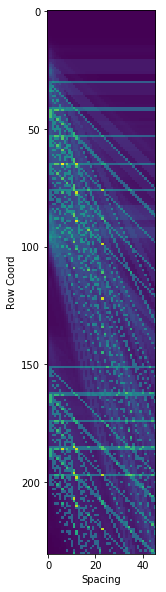

In [8]:
image_path = './music1.png'
omr_obj = omr(image_path)
accumulator = omr_obj.hough_transform(image_path)
omr_obj.plot_hough_transform_space(accumulator)
row_coordinate_treble_stave, row_coordinate_base_stave, spacing_parameter= omr_obj.get_coordinates_spacing(accumulator)

image file  music1.png music1
[(30, 'F'), (42, 'D'), (54, 'B'), (66, 'G'), (78, 'E'), (151, 'A'), (163, 'F'), (175, 'D'), (187, 'B'), (199, 'G')]
[30, 42, 54, 66, 78, 151, 163, 175, 187, 199]
image shape:  (231, 1274)
image shape:  (231, 1274)
temp file  template1.png
image shape:  (11, 17)
image shape:  (11, 17)
f_ij_scaled  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
loc (array([ 20,  20,  20,  21,  21,  26,  26,  26,  26,  26,  26,  38,  38,
        38,  38,  38,  38,  49,  49,  49,  49,  49,  49,  49,  49,  49,
        49,  55,  55,  56,  60,  61,  61,  61,  61,  61,  61,  64,  65,
        66,  66,  67,  67,  67,  67,  68,  68,  78,  78,  82,  82,  82,
        82,  82,  82,  82,  83,  88,  88,  88,  88,  88,  88,  88,  88,
        89,  91,  91, 136, 136, 150, 152, 152, 153, 153, 153, 163, 170,
       170, 173, 173, 173, 175, 175, 175, 175, 175, 175, 175, 186, 186,
       187, 193], dtype=int64), array([ 123

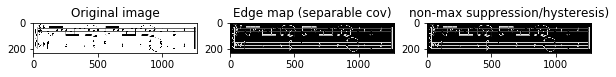

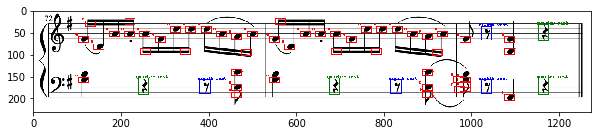

In [15]:
for img in glob.glob("./music1.png"):
    img_file_path, img_file_name = os.path.split(img)
    img_file_name_noext = os.path.splitext(img_file_name)[0]
    print("image file ", img_file_name, img_file_name_noext)
    omr_obj = omr(img)
    img_obj, img_array = omr_obj.return_img_array()

    # colors for the 3 templates 
    colors = ['red','green','blue']
    coordinates = [(0,0)]
    
    # set hamming ditance thresholds 
    if img_file_name_noext == 'music1':
        ham_threshold = [220,250,245]
    elif img_file_name_noext == 'music2':
        ham_threshold = [230,254,237]
    elif img_file_name_noext == 'music3':
        ham_threshold = [220,253,252]
    elif img_file_name_noext == 'music4':
        ham_threshold = [220,253,220]
    else:
        ham_threshold = [220,250,235]

    treble_notes = ['F','D','B','G','E']
    base_notes = ['A','F','D','B','G']
    list_notes = []
    for x in enumerate(range(row_coordinate_treble_stave,row_coordinate_treble_stave+5*spacing_parameter,spacing_parameter)):
      list_notes.append((x[1],treble_notes[x[0]]))

    for x in enumerate(range(row_coordinate_base_stave,row_coordinate_base_stave+5*spacing_parameter,spacing_parameter)):
      list_notes.append((x[1],base_notes[x[0]]))

    print(list_notes)

    list_coordinates = [a_tuple[0] for a_tuple in list_notes]
    print(list_coordinates)

    # comment below for Canny Edge Detection
    edge_sobel_img_final, edge_sobel_img_theta = omr_obj.edge_detect_sobel(img_array)
#    edge_sobel_img_final, edge_sobel_img_theta = omr_obj.edge_detect_sobel_separable(img_array)

    #uncomment below for Canny Edge Detection
#    edge_sobel_img_array, edge_sobel_img_theta = omr_obj.edge_detect_sobel(img_array)
#    edge_sobel_img_array, edge_sobel_img_theta = omr_obj.edge_detect_sobel_separable(img_array)
#    edge_sobel_nonMaxImg = omr_obj.non_max_suppression(edge_sobel_img_array, edge_sobel_img_theta)
#    edge_sobel_thresholdImg = omr_obj.threshold(edge_sobel_nonMaxImg)
#    edge_sobel_img_final = omr_obj.hysteresis(edge_sobel_thresholdImg)

    fig, axs = plt.subplots(1, 3, figsize=(10,8))
    axs[0].imshow(img_array, 'gray')
    axs[0].set_title("Original image")
    axs[1].imshow(edge_sobel_img_final, 'gray')
    axs[1].set_title("Edge map (separable cov)")
    axs[2].imshow(edge_sobel_img_final, 'gray')
    axs[2].set_title("non-max suppression/hysteresis)")
    
    i = 0
    img_outfile = 'detected_' + img_file_name
    txt_outfile = 'detected_' + img_file_name_noext + '.txt'
    notes = []
    img_RGB = img_obj.convert('RGB')
    draw = ImageDraw.Draw(img_RGB)
    for file in glob.glob("./template*.PNG"):
        tmp_file_path, tmp_file_name = os.path.split(file)
        print("temp file ", tmp_file_name)
        tmp_img_array, tmp_img_obj, tmp_img_width, tmp_img_height = omr_obj.return_tmp_img_array(file)
        tmp_img_RGB = tmp_img_obj.convert('RGB')
        # comment below for Canny Edge Detection
        edge_sobel_tmp_img_final, edge_sobel_tmp_img_theta = omr_obj.edge_detect_sobel(tmp_img_array)
#        edge_sobel_tmp_img_final, edge_sobel_tmp_img_theta = omr_obj.edge_detect_sobel_separable(tmp_img_array)
    
        #uncomment below for Canny Edge Detection
#        edge_sobel_tmp_img_array, edge_sobel_tmp_img_theta = omr_obj.edge_detect_sobel(tmp_img_array)
#        edge_sobel_tmp_img_array, edge_sobel_tmp_img_theta = omr_obj.edge_detect_sobel_separable(tmp_img_array)

#        edge_sobel_tmp_nonMaxImg = omr_obj.non_max_suppression(edge_sobel_tmp_img_array, edge_sobel_tmp_img_theta)
#        edge_sobel_tmp_thresholdImg = omr_obj.threshold(edge_sobel_tmp_nonMaxImg)
#        edge_sobel_tmp_img_final = omr_obj.hysteresis(edge_sobel_tmp_thresholdImg)
    
        ham_distance = [omr_obj.hamming_distance(edge_sobel_img_final, edge_sobel_tmp_img_final)]
        images = np.asarray([(np.where(ham_distance[j] > ham_threshold[i],255,0)) for j in range(len(ham_distance))])
        images = np.squeeze(images)
#        print("images ", images.shape, images)
        loc = np.where(images == 255)
        print("loc", loc)
        box_endpoints = []
        for pt in zip(*loc[::-1]):
            x = pt[1]
            y = pt[0]
            x2 = x + tmp_img_height
            y2 = y + tmp_img_width
            box_endpoints.append([y,x,y2,x2])
        boxes_out = omr_obj.eliminate_duplicate_bbox(boxes=np.array(box_endpoints), overlap_threshold=0.3)
        for box in boxes_out:
            if box[0] >65  and box[1]>10 :
                draw.rectangle(((box[0]-6,box[1]-2),(box[2]+1,box[3]+1)), outline= colors[i], width=2) 
                if i == 0:
                    symbol = 'offilled_note'
                    pitch = omr_obj.return_notes(list_coordinates,box[1])
                    draw.text((box[0]-12,box[1]-12), pitch, fill='red')
                elif i == 1:
                    symbol = 'quarter rest'
                    pitch = '_'
                    draw.text((box[0]-10,box[1]-10), symbol, fill='green')
                elif i == 2:
                    symbol = 'eighth rest'
                    pitch = '_'
                    draw.text((box[0]-10,box[1]-10), symbol, fill='blue')
        
            bbox=np.array([[box[0],box[1]], [box[2],box[3]]])
            confidence = omr_obj.confidence_score(img_RGB, tmp_img_RGB, bbox)
            note = 'image: ' + img_file_name + " template: " + tmp_file_name + " row: " + str(box[1]) + " col: " \
            + str(box[0]) + " height: " + str(tmp_img_height) + " width: " + str(tmp_img_width) + " symbol: " \
            + symbol + " pitch: " + pitch + " confidence: " + str(round(confidence,3))
            notes.append(note)
        i += 1
    img_RGB.save(img_outfile)
    with open(txt_outfile, 'w') as f:
        for item in notes:
            f.write("%s\n" % item)
            print(item)
    f.close()
    plt.figure(figsize=(10,10))
    plt.imshow(img_RGB)
plt.show()
